In [79]:
import load_data

from keras.datasets import mnist
import matplotlib.pyplot as plt


from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils

from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import datetime
import cv2
import math

import pickle

import helper_functions as hf
import segment_helper_functions as seg_hf

import recursive_profile_cutting as rpc

In [80]:
reload(load_data)
reload(hf)
reload(seg_hf)
reload(rpc)

<module 'recursive_profile_cutting' from 'recursive_profile_cutting.py'>

In [3]:
hparams = {}
hparams['model'] = "BASELINE" # "BASELINE", "CONVNET1"
hparams['augmented_data'] = False
hparams['crop_width'] = 30
hparams['crop_height'] = 35
hparams['dsample_factor'] = 0.6

hparams['epochs'] = 5


hparams['load_from_pickle'] = False
hparams['save_to_pickle'] = False # Currently super slow

In [4]:
if hparams['load_from_pickle']:
    data_pickle = pickle.load( open( "data_pickle.p", "rb" ) )
    X = data_pickle['X']
    Y = data_pickle['Y']
    num_unique = data_pickle['num_unique']
    target_token_index = data_pickle['target_token_index']  
else:
    X, Y, num_unique, target_token_index = load_data.load_math_symbols()
    if hparams['save_to_pickle']:
        data_pickle = {'X': X, 'Y': Y, 'num_unique': num_unique, 'target_token_index': target_token_index}
        pickle.dump( data_pickle, open( "data_pickle.p", "wb" ) )
    

## Todo: Save and load from pickle

('Max width: ', 120)
('Min width: ', 5)
('Mean width: ', 35.558135254894744)
('Max height: ', 188)
('Min heigh: ', 2)
('Mean height: ', 47.714696263997624)
('Number of examples: ', 70637)


In [6]:
reverse_target_token_index = dict(
    (i, token) for token, i in target_token_index.items())

orig_shape = (X.shape[1], X.shape[2])
X, Y = hf.shuffle_data(X,Y, seed=100)

In [7]:
hex_to_token_dict = load_data.get_hex_to_token_dict()

In [15]:
# Down sample images

X_small = hf.down_sample(X, hparams['dsample_factor'])

In [16]:
## Split up to train/val set and test set

Y = np_utils.to_categorical(Y, num_classes = num_unique)

X_train = X_small[:60000]
X_test = X_small[60000:]

Y_train = Y[:60000]
Y_test = Y[60000:]


In [19]:
def augment_data(X,Y, num_samples):
    shift = 0.05
    zoom = 0.1
    shear = 0.2
    datagen = ImageDataGenerator(zoom_range=zoom, width_shift_range=shift, height_shift_range=shift)
    #datagen = ImageDataGenerator(zoom_range=zoom)


    # fit parameters from data
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2], 1))
    datagen.fit(X)
    # Configure batch size and retrieve one batch of images

    for X_batch, y_batch in datagen.flow(X, Y_train, batch_size=num_samples):
        # Show 9 images
        for i in range(0, 9):
            plt.subplot(330 + 1 + i)
            plt.imshow(np.squeeze(X_batch[i]), cmap='gray')
        # show the plot
        plt.show()

        return X_batch, y_batch


In [21]:
if hparams['augmented_data']:
    X_train_augmented, Y_train_augmented = augment_data(X_train,Y_train, 100000)

In [22]:
X_test = hf.crop_images(X_test, hparams['crop_width'], hparams['crop_height'])

if hparams['augmented_data']:
    X_train = hf.crop_images(X_train_augmented, hparams['crop_width'], hparams['crop_height'])
else:
    X_train = hf.crop_images(X_train, hparams['crop_width'], hparams['crop_height'])


In [23]:
## Normalize and invert
X_test_normalized = hf.normalize_and_invert(X_test)
X_train_normalized = hf.normalize_and_invert(X_train)

In [24]:
## Reshape images depending on model


if hparams['model'] == "BASELINE":

    X_train_vecs = hf.flatten(X_train_normalized)
    X_test_vecs = hf.flatten(X_test_normalized)

#If we are using a convnet
else:
    X_train_vecs = hf.add_dimension(X_train_normalized)
    X_test_vecs = hf.add_dimension(X_test_normalized)

if hparams['augmented_data']:
    Y_train = Y_train_augmented


In [25]:
assert Y_train.shape[0] == X_train_vecs.shape[0]

In [26]:
# BOTH MODELS FROM https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/
num_pixels = X_train_vecs.shape[1]
num_classes = Y_test.shape[1]

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# define the larger model
def convnet1(image_size):
    # create model
    
    height = image_size[0]
    width = image_size[1]
    
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(height, width, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def convnet2(image_size):
    # create model
    
    height = image_size[0]
    width = image_size[1]
    
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(height, width, 1), activation='relu'))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [27]:
# build the model

if hparams['model'] == "BASELINE":
    print("Training BASELINE")
    model = baseline_model()
elif hparams['model'] == "CONVNET1":
    print("Training CONVNET1")
    model = convnet1((hparams['crop_height'], hparams['crop_width']))
elif hparams['model'] == "CONVNET2":
    model = convnet2((hparams['crop_height'], hparams['crop_width']))
# Fit the model


fit_history = model.fit(X_train_vecs, Y_train, validation_split=0.10, epochs=hparams['epochs'], batch_size=200, verbose=2)
# Final evaluation of the model




Train on 54000 samples, validate on 6000 samples
Epoch 1/5
 - 15s - loss: 0.5191 - acc: 0.9000 - val_loss: 0.1572 - val_acc: 0.9677
Epoch 2/5
 - 14s - loss: 0.0955 - acc: 0.9777 - val_loss: 0.1025 - val_acc: 0.9803
Epoch 3/5
 - 13s - loss: 0.0565 - acc: 0.9872 - val_loss: 0.0969 - val_acc: 0.9838
Epoch 4/5
 - 14s - loss: 0.0438 - acc: 0.9899 - val_loss: 0.0894 - val_acc: 0.9842
Epoch 5/5
 - 13s - loss: 0.0369 - acc: 0.9919 - val_loss: 0.0922 - val_acc: 0.9845


In [28]:
scores = model.evaluate(X_test_vecs, Y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Baseline Error: 1.62%


['acc', 'loss', 'val_acc', 'val_loss']


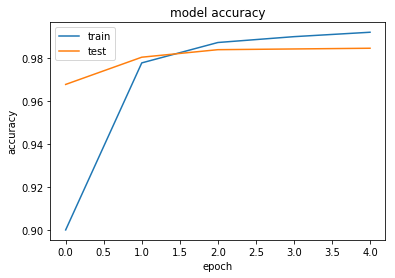

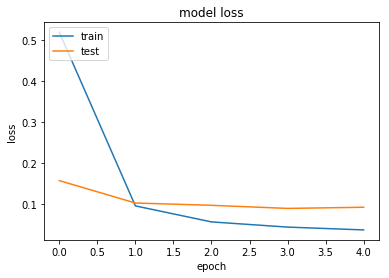

In [32]:
hf.visualize_training_history(fit_history)


In [ ]:
## SEGMENTING EQUATIONS

In [35]:
## Load Equation dataset

equation_images = load_data.load_equations(40) 

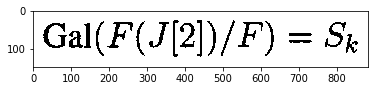

In [38]:


plt.imshow(equation_images[39], cmap='gray')
plt.show()

In [52]:
def show_segmented_equation(equation_image, smaller_images, show_each_symbol=False):


    backtorgb = np.copy(equation_image)
    plt.imshow(equation_image, cmap='gray')

    for image_with_position in smaller_images:

        plt.show()

        smaller_image = image_with_position['image']
        smaller_image_shape = image_with_position['image'].shape

        corner1y = image_with_position['position'][0]
        corner1x = image_with_position['position'][1]
        corner1 = (corner1x, corner1y)

        corner2y = corner1y + smaller_image_shape[0] - 1
        corner2x = corner1x + smaller_image_shape[1]

        corner2 = (corner2x, corner2y) # x, y

        cv2.rectangle(backtorgb,corner1,corner2,(0,255,0),3)


        if show_each_symbol:
            
            print("Predicted token: ", image_with_position['predicted_token'])
            plt.imshow(smaller_image, cmap='gray')
            plt.show()


    plt.imshow(backtorgb, cmap='gray')
    plt.show()

In [41]:
#smaller_images[0].shape

#padded_images

In [42]:
#40 35

ta_size = orig_shape






In [85]:
def preprocess_images_for_predict(smaller_images, orig_shape):
    padded_images = hf.pad_images(smaller_images, orig_shape)

    down_sampled_images = hf.down_sample(padded_images,hparams['dsample_factor'])

    h = down_sampled_images.shape[1]
    w = down_sampled_images.shape[2]

    h_start = int(h / 2 - hparams['crop_height'] / 2)
    w_start = int(w / 2 - hparams['crop_width'] / 2)


    final_images = down_sampled_images[:, h_start:h_start+hparams['crop_height'], w_start:w_start+hparams['crop_width']]
    
    return final_images

In [54]:

#image_to_predict = np.reshape(X_train[611], (1, X_train[611].shape[0]*X_train[611].shape[1]))

In [55]:
def last_step_before_predict(final_images):
    images_to_predict = np.reshape(final_images, (final_images.shape[0], final_images.shape[1]*final_images.shape[2]))
    images_to_predict = 255 - images_to_predict
    images_to_predict = images_to_predict.astype('float')
    images_to_predict = images_to_predict / 255.0
    return images_to_predict


In [56]:
def predict_smaller_images(images, orig_shape):

    
    images_with_positions = images

    smaller_images = seg_hf.get_just_images(images)
    
    final_images = preprocess_images_for_predict(smaller_images, orig_shape)
    images_to_predict = last_step_before_predict(final_images)
    output = model.predict(images_to_predict)
    tokenids = np.argmax(output, axis=1)
    #print(len(tokenids))
    
    for idx, o in enumerate(tokenids):
        hexa = reverse_target_token_index[o]

        token = hex_to_token_dict[hexa]
        #real_output.append([token, o])
        images[idx]['predicted_token_id'] = o

        images[idx]['id'] = idx
        images[idx]['predicted_token'] = token
        
    return images

In [57]:
# Learned this from: https://stackoverflow.com/questions/8242832/python-all-possible-pairs-of-2-list-elements-and-getting-the-index-of-that-pair
import itertools
def all_pairs(lst):
    for p in itertools.combinations(lst,2):
        i = iter(p)
        yield zip(i,i)

In [87]:
def check_if_equal_sign(image_1,image_2):
    predicted1 = image_1['predicted_token']
    predicted2 = image_2['predicted_token']
    
    if predicted1 != 'minus' or predicted2 != 'minus':
        return False
    
    
    w1 = image_1['image'].shape[1]
    w2 = image_2['image'].shape[1]
    
    cx1 = seg_hf.get_center_from_image(image_1)[1]
    cx2 = seg_hf.get_center_from_image(image_2)[1]
    
    
    
    if np.abs(w1-w2) > 4:
        return False
    if np.abs(cx1 - cx2) > 4:
        return False
    
    return True

In [107]:
def check_if_lc_i(image_1,image_2):
    predicted1 = image_1['predicted_token']
    predicted2 = image_2['predicted_token']
    
    top_symbols = ['comma', 'prime', 'ast']
    bottom_symbols = ['one', 'l']
    
    w1 = image_1['image'].shape[1]
    w2 = image_2['image'].shape[1]
    
    cx1 = seg_hf.get_center_from_image(image_1)[1]
    cx2 = seg_hf.get_center_from_image(image_2)[1]
    
    if np.abs(w1-w2) > 10:
        return False
    if np.abs(cx1 - cx2) > 10:
        return False
    
    
    if is_on_top(image_1, image_2):
        if (predicted1 in top_symbols and predicted2 in bottom_symbols):
            return True
    elif is_on_top(image_2, image_1):
        if (predicted1 in bottom_symbols and predicted2 in top_symbols):
            return True
    
    
    
    return False


In [91]:
## Works

def is_on_top(image_1, image_2):
    centery1, centerx1 = seg_hf.get_center_from_image(image_1)
    centery2, centerx2 = seg_hf.get_center_from_image(image_2)
    
    if centery1 < centery2:
        
        return True
    elif centery1 >= centery2:
        return False
    

In [92]:
def concat_images(image_1, image_2):
    
    if is_on_top(image_1, image_2):
        print("Is on top")
        new_y1 = image_1['position'][0]
        new_x1 = min(image_1['position'][1],image_2['position'][1])
        
        yoffset = image_2['position'][0] - image_1['position'][0] - image_1['image'].shape[0]
        
        image_2_height = image_2['image'].shape[0]
        image_2_width = image_2['image'].shape[1]
        
        image_1_height = image_1['image'].shape[0]
        image_1_width = image_1['image'].shape[1]
        
        new_height = image_1_height + image_2_height + yoffset
        new_width = max(image_1_width, image_2_width)
        
        new_image = 255 * np.ones((new_height, new_width))
        
        new_image[:image_1_height, :image_1_width] = image_1['image']
        new_image[image_1_height+yoffset:, :image_2_width] = image_2['image']
    else:
        new_y1 = image_2['position'][0]
        new_x1 = min(image_1['position'][1],image_2['position'][1])

        yoffset = image_1['position'][0] - image_2['position'][0] - image_2['image'].shape[0]
        image_2_height = image_2['image'].shape[0]
        image_2_width = image_2['image'].shape[1]
        
        image_1_height = image_1['image'].shape[0]
        image_1_width = image_1['image'].shape[1]
        
        new_height = image_1_height + image_2_height + yoffset
        new_width = max(image_1_width, image_2_width)
        
        new_image = 255 * np.ones((new_height, new_width))
        print("Showing image 2: ")
        plt.imshow(image_2['image'])
        plt.show()
        print("position: ", image_2['position'])
        
        print("Showing image 1: ")
        plt.imshow(image_1['image'])
        plt.show()
        print("position: ", image_1['position'])
        
        new_image[:image_2_height, :image_2_width] = image_2['image']
        print("new_height: ", new_height)
        print("yoffset: ", yoffset)
        print("image_1 shape", image_1['image'].shape)
        new_image[image_2_height+yoffset:, :image_1_width] = image_1['image']
    
    
    new_image_with_position = {}
    new_image_with_position['image'] = new_image
    new_image_with_position['position'] = (new_y1, new_x1)
    
    
    return new_image_with_position

In [93]:
def find_lc_is(images):
    ids_to_remove = []
    
    new_predicted_images = []
    new_list = all_pairs(images)
    
    lower_case_is = []
    
    for pair in new_list:
        
        image_1 = pair[0][0]
        image_2 = pair[0][1]
        #print(image_1['id'])
        #print(image_2['id'])
        if check_if_lc_i(image_1,image_2):
            new_image = concat_images(image_1, image_2)
            #print("found one equal sign")
            ids_to_remove.append(image_1['id'])
            ids_to_remove.append(image_2['id'])

            new_image['id'] = image_1['id']
            new_image['predicted_token'] = 'i'
            lower_case_is.append(new_image)
    
    
    
    for image in images:
        if image['id'] not in ids_to_remove:
            new_predicted_images.append(image)
    
    for lower_case_i in lower_case_is:
        new_predicted_images.append(lower_case_i)
    
    return new_predicted_images

In [94]:
def find_equal_signs(images):
    ids_to_remove = []
    
    new_predicted_images = []
    
    equal_signs = []
    new_list = all_pairs(images)
    for pair in new_list:
        
        image_1 = pair[0][0]
        image_2 = pair[0][1]

        if check_if_equal_sign(image_1,image_2):
            new_image = concat_images(image_1, image_2)
            #print("found one equal sign")
            ids_to_remove.append(image_1['id'])
            ids_to_remove.append(image_2['id'])

            
            new_image['id'] = image_1['id']
            new_image['predicted_token'] = 'equal'
            equal_signs.append(new_image)
    
    
    
    for image in images:
        if image['id'] not in ids_to_remove:
            new_predicted_images.append(image)
    
    for equal_sign in equal_signs:
        new_predicted_images.append(equal_sign)
    
    return new_predicted_images

In [95]:
def apply_rules(predicted_images):
    images_processed = find_equal_signs(predicted_images)
    images_processed = find_lc_is(images_processed)
    
    return images_processed

In [96]:
#new_list = all_pairs(predicted_images)



In [97]:
def get_image_area(image_with_position):
    image_shape = image_with_position['image'].shape
    return image_shape[0] * image_shape[1]

In [98]:

def segment_and_apply_rules(equation_image, orig_shape):


    img_with_positions = rpc.segment_equation(equation_image)
    show_segmented_equation(equation_image, img_with_positions)

    predicted_images = predict_smaller_images(img_with_positions, orig_shape)
    rules_applied = apply_rules(predicted_images)

    show_segmented_equation(equation_image, rules_applied)


In [99]:
def get_relative_position(image_1, image_2, properties):
    image1_shape = image_1['image'].shape
    image2_shape = image_2['image'].shape
    
    if len(properties) > 0:
        last_property = properties[-1]
    else:
        last_property = (None, None)
    
    image1_h = image1_shape[0]
    image2_h = image2_shape[0]
    
    positiony1 = image_1['position'][0]
    positionx1 = image_1['position'][1]
    
    positiony2 = image_2['position'][0]
    positionx2 = image_2['position'][1]
    
    centery1, centerx1 = seg_hf.get_center_from_image(image_1)
    centery2, centerx2 = seg_hf.get_center_from_image(image_2) 
    
    # Below, above, sup or sub
    
    if last_property[0] == "SUBRIGHT":
        if positiony2 < last_property[1] + 3:
            properties.pop()
            return ("PREVIOUS", properties)
        
    if last_property[0] == "SUPRIGHT":
        if positiony2 + image2_h > last_property[1] - 3:
            properties.pop()
            return ("PREVIOUS", properties)
    
    if image2_h < image1_h:
        ## Below
        if (centerx2 > positionx1) and centerx2 < positionx1+image1_shape[1] and positiony2 > positiony1 + image1_shape[0]:
            return ("BELOW", properties)

        ## Above
        if centerx2 > positionx1 and centerx2 < positionx1+image1_shape[1] and positiony2 + image2_shape[0] < positiony1:
            return ("ABOVE", properties)


        ## Subscript right
        if centerx1 < positionx2 and positiony2 > centery1:
            properties.append(("SUBRIGHT", centery1))
            return ("SUBRIGHT", properties)

        ## Superscript right
        if centerx1 < positionx2 and positiony2+image2_shape[0] < centery1:
            properties.append(("SUPRIGHT", centery1))
            return ("SUPRIGHT", properties)
        
    ## To the right
    return ("RIGHT", properties)

In [100]:
equation_image = equation_images[4]


In [101]:
#for imgg in rules_applied:
    #plt.imshow(imgg['image'])
    #plt.show()


In [102]:
def sort_images(images):
    newlist = sorted(images, key=lambda k: k['id']) 
    return newlist

def structural_analysis_and_latex(images):

    images = sort_images(images)

    latex_string = ""
    prop = []
    for idx in range(len(images)):
        if idx == len(images) - 1:
            latex = seg_hf.get_latex(images[idx]['predicted_token'])
            latex_string += " " + latex
            if len(prop) != 0:
                latex_string += " }"
            break


        rel_pos, props = get_relative_position(images[idx], images[idx+1], prop)
        prop = props


        latex = seg_hf.get_latex(images[idx]['predicted_token'])

        latex_string += " " + latex
        if rel_pos == "SUBRIGHT":
            latex_string += "_{"
        elif rel_pos == "PREVIOUS":
            latex_string += " }"
        elif rel_pos =="SUPRIGHT":
            latex_string += "^{"
        print(rel_pos)
    
    return latex_string


In [103]:
def image_to_latex(equation_image, show_segmentation=False, show_each_symbol=False):
    img_with_positions = rpc.segment_equation(equation_image)
    predicted_images = predict_smaller_images(img_with_positions, orig_shape)
    rules_applied = apply_rules(predicted_images)
    if show_segmentation:
        ims= sort_images(rules_applied)
        show_segmented_equation(equation_image, ims, show_each_symbol=show_each_symbol)
    return structural_analysis_and_latex(rules_applied)

In [104]:

#hex_to_token_dict[reverse_target_token_index[id_token]]

In [105]:
equation_image = equation_images[4]

Is on top


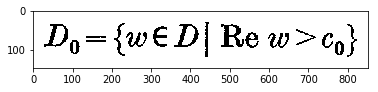

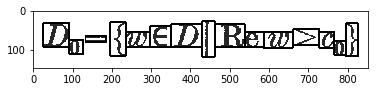

SUBRIGHT
PREVIOUS
RIGHT
RIGHT
RIGHT
RIGHT
RIGHT
RIGHT
RIGHT
RIGHT
RIGHT
RIGHT
SUBRIGHT
PREVIOUS
 D_{ w } = \RightBracket w \in D \LeftBracket B \in w > c_{ 0 } \RightBrace


In [109]:
print(image_to_latex(equation_image, show_segmentation=True, show_each_symbol=False))

In [ ]:





    
print(latex_string)

In [ ]:
for img in rules_applied:
    plt.imshow(img['image'], cmap='gray')
    plt.show()

In [ ]:
rules_applied

pairs_of_images = all_pairs(rules_applied)

# edge (id1, id2, )


    